In [1]:
# uncomment local imports, comment google drive file import
# this version is not dependent on utils folder
# make changes by other

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
# !pip install torchinfo optuna

# **Imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

# import nndl.models.CNN as cnn
# import nndl.models.CNNLSTM as clstm
# import nndl.models.GRU as gru
# import nndl.utils as utils
import time
import gc

In [4]:
# seeds
# import random
# random.seed(0)
# np.random.seed(464302549)
# torch.manual_seed(4643025497122690148)

#random.seed(14399246544918688587)
#torch.manual_seed(14399246544918688587)
#np.random.seed(14399246544918688587)

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Load data from localhost**

In [6]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# Load data from google drive

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# ## Loading the dataset
# X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
# y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")-769
# person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")
# X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
# y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")-769
# person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
# print("---all data---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("person_test shape\t", person_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)
# print("person_train_valid shape", person_train_valid.shape)
# print()

# Load data for a subset of subjects

In [9]:
# # subjects is to load a subset of the data for a particular subject
# subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8] #use 0-8 for subjects 1-9
# # subjects = [0] #use 0-8 for subjects 1-9

# X_test_subs = np.empty((0, X_test.shape[1], X_test.shape[2]))
# y_test_subs = np.empty((0))
# X_train_valid_subs = np.empty((0, X_train_valid.shape[1], X_train_valid.shape[2]))
# y_train_valid_subs = np.empty((0))

# for i in subjects:
#   sub = i
#   X_test_subs = np.concatenate( (X_test_subs, X_test[np.where(person_test == sub)[0],:,:] ))
#   y_test_subs = np.concatenate( (y_test_subs, y_test[np.where(person_test == sub)[0]] ))
#   X_train_valid_subs = np.concatenate(( X_train_valid_subs, X_train_valid[np.where(person_train_valid == sub)[0], :, :] ))
#   y_train_valid_subs = np.concatenate(( y_train_valid_subs, y_train_valid[np.where(person_train_valid == sub)[0]] ))

# X_test = X_test_subs
# y_test = y_test_subs
# X_train_valid = X_train_valid_subs
# y_train_valid = y_train_valid_subs
# print("---after isolating subjects---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)

# train_model and test_model functions

In [10]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader=None,
                val_loader=None,
                test_loader=None,
                num_epochs=100,
                learning=False,
                device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'),
                trial=None):
    # we return these
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')

        # ======================================================================
        # START OF TRAINING
        # ======================================================================
        model.train()
        train_count = 0
        train_correct_count = 0

        # minibatch
        for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)

            logits = model(train_x)
            loss = criterion(logits, train_y)

            optimizer.zero_grad()   # no gradient accumulation between batches
            loss.backward()         # backprop
            optimizer.step()        # gradient step

            # training accuracy
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_accuracies.append(train_acc.item())
        # ======================================================================
        # END OF TRAINING
        # ======================================================================

        # ======================================================================
        # START OF VALIDATION
        # ======================================================================
        model.eval()
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        # validation accuracy
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)

                logits = model(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)

                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_y.size(0)

                # for the learning rate scheduler
                val_loss = criterion(logits, val_y)

        val_acc = val_correct_count / val_count
        val_accuracies.append(val_acc.item())
        scheduler.step(val_loss)
        # ======================================================================
        # END OF VALIDATION
        # ======================================================================

        # performance info
        print('Train acc: {:.3f}, Val acc: {:.3f}, Val loss: {:.3f}'.format(train_acc,
                                                                            val_acc,
                                                                            val_loss))

        if learning:
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================
            trial.report(val_acc.item(), epoch)
            # so my gpu doesn't shit itself, also gets rid of shit trials
            if trial.should_prune():
                # garbage collection so my gpu doesn't shit itself
                del model
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================

    if learning:
        # garbage collection so my gpu doesn't shit itself
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return train_accuracies, val_accuracies
# ==============================================================================
# END OF train_model()
# ==============================================================================


# ==============================================================================
# START OF test_model()
# ==============================================================================
def test_model(model,
               test_loader,
               device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')):
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0

        for _, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)

            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)

            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)

        test_acc = test_correct_count / test_count
        print('Test acc: {:.3f}'.format(test_acc))
# ==============================================================================
# END OF test_model()
# ==============================================================================

# **Data Prep**

In [11]:
def data_prep(X,y,sub_sample,average,noise,p_channel_dropout,smooth_time_mask,mask_length):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if p_channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= p_channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if smooth_time_mask:
        copy_X = copy.deepcopy(total_X)
        starts = ((torch.rand(copy_X.shape[0])*(copy_X.shape[2]-mask_length-1))).round()
        for idx, m in enumerate(copy_X):
            start = int(starts[idx])
            end = start+mask_length
            m[:,start:end] = 0
        total_X = torch.cat((total_X, copy_X))
        total_y = torch.cat((total_y, total_y))
        print(f'Shape of X after smooth time mask {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    return total_X,total_y

def test_data_prep(X):
    total_X = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X


input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 64
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
p_channel_dropout = 0
smooth_time_mask = False
mask_size = 120
noise = False
'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_val by subject using person_valid
#############################################
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [213, 207, 214, 207, 215, 217, 217, 206, 207]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([213, 22, 800])
Shape of X after maxpooling: torch.Size([213, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([426, 22, 400])
torch.Size([426, 1])
torch.Size([213, 1])
torch.Size([639, 1])
torch.Size([213, 1])
Shape of X after subsampling and concatenating: torch.Size([852, 22, 400])
Shape of Y: torch.Size([852])

subject 1
Shape of X after trimming: torch.Size([207, 22, 800])
Shape of X after maxpooling: torch.Size([207, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([414, 22, 400])
torch.Size([414, 1])
torch.Size([207, 1])
torch.Size([621, 1])
torch.Size([207, 1])
Shape of X after subsampling and concatenating: torch.Size([828, 22, 400])
Shape of Y: torch.Size([828])

subject 2
Shape of X after trimming: torch.Size([214, 22, 800])
Shape of X after maxpooling: torch.

In [12]:
# num_epochs = 50
# num_trials = 20
# start_time = time.time()

# **GRU**

In [13]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='GRU',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [14]:
# model = gru.GRU(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [15]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [16]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [17]:
# utils.test_model(model, test_loader)

In [18]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNN**

In [19]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNN',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [20]:
# model = cnn.CNN(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [21]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [22]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [23]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [24]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNNLSTM**

In [25]:
# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         tmp = x.contiguous().view(-1, x.size(-1))
#         y = self.layer(tmp)
#         y = y.contiguous().view(x.size(0), -1, y.size(-1))

#         return y

In [26]:
# class CNNLSTM(nn.Module):
#     def __init__(self,
#                  num_classes=4,
#                  hidden_dims=256,
#                  num_layers=2,
#                  dropout=0.5,
#                  kernel=5,
#                  stride=2,
#                  padding=0,
#                  pool_kernel=2,
#                  time_bins=400,
#                  channels=22,
#                  depth=32):
#         super(CNNLSTM, self).__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=channels,
#                       out_channels=depth,
#                       kernel_size=kernel,
#                       stride=stride,
#                       padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.MaxPool1d(kernel_size=pool_kernel),
#             nn.Dropout(dropout)
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 2,
#                       stride=stride,
#                       padding=padding + 1),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth * 4,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 5),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth * 4),
#             nn.Dropout(dropout)
#         )

#         self.lstm1 = nn.LSTM(input_size=depth * 4,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.lstm2 = nn.LSTM(input_size=hidden_dims,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.td = nn.Sequential(
#             TimeDistributed(nn.Linear(in_features=hidden_dims,
#                                       out_features=hidden_dims // 2)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
#             TimeDistributed(nn.Dropout(dropout)),

#             TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
#                                       out_features=hidden_dims // 4)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
#             TimeDistributed(nn.Dropout(dropout)),
#         )

#         self.dense = nn.Linear(in_features=hidden_dims // 4,
#                                out_features=num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = x.transpose(1, 2)
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x = self.td(x)
#         x = x[:, -1, :]
#         x = self.dense(x)
#         return F.log_softmax(x, dim=1)




In [27]:
# torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [28]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNNLSTM',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [29]:
# model = clstm.CNNLSTM(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [30]:
# model = CNNLSTM().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [31]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [32]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [33]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [34]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [35]:
# end_time = time.time()
# print('time i will never get back:')
# hours = (end_time - start_time) // 3600
# minutes = ((end_time - start_time) % 3600) // 60
# seconds = (end_time - start_time) % 60

# print(f'time to train models: \
# {hours} hours, \
# {minutes} minutes, \
# {int(seconds)} seconds')

# other

In [11]:
# update number of epochs
# change path to save
number_epochs = 100
path_to_save = './results_new/'
super_start_time = time.time()

In [37]:
def calc_time(end_time, start_time):
  hours = (end_time - super_start_time) // 3600
  minutes = ((end_time - super_start_time) % 3600) // 60
  seconds = (end_time - super_start_time) % 60

  print(f'time to train model: \
  {hours} hours, \
  {minutes} minutes, \
  {int(seconds)} seconds')

## cnn

In [38]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [39]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 4),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        x = self.nd(x)
        x = x[:, -1, :]
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [40]:
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 391]             --
│    └─Conv1d: 2-1                       [64, 25, 391]             5,525
│    └─ReLU: 2-2                         [64, 25, 391]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 391]             50
│    └─Dropout: 2-4                      [64, 25, 391]             --
├─Sequential: 1-2                        [64, 50, 1, 122]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 367]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 367]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 367]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 122]          --
│    └─Dropout: 2-9                      [64, 50, 1, 122]          --
├─Sequential: 1-3                        [64, 100, 37]             --
│    └─

In [41]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.00189, weight_decay=0.00087)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=0.00005)

In [42]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.475, Val loss: 1.292
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.560, Val acc: 0.592, Val loss: 1.042
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.648, Val acc: 0.587, Val loss: 1.038
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.701, Val acc: 0.618, Val loss: 1.035
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.734, Val acc: 0.643, Val loss: 1.039
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.761, Val acc: 0.616, Val loss: 1.150
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.785, Val acc: 0.641, Val loss: 1.026
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.806, Val acc: 0.641, Val loss: 1.050
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.817, Val acc: 0.703, Val loss: 1.224
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.835, Val acc: 0.675, Val loss: 1.221
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.848, Val acc: 0.688, Val loss: 1.228
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.675, Val loss: 1.226
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.874, Val acc: 0.701, Val loss: 1.300
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.879, Val acc: 0.690, Val loss: 1.152
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.677, Val loss: 1.273
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.696, Val loss: 1.192
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.904, Val acc: 0.706, Val loss: 1.195
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.690, Val loss: 1.215
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.918, Val acc: 0.707, Val loss: 1.124
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.928, Val acc: 0.715, Val loss: 1.273
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.710, Val loss: 1.289
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.936, Val acc: 0.710, Val loss: 1.256
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.705, Val loss: 1.284
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.711, Val loss: 1.307
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.711, Val loss: 1.319
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.718, Val loss: 1.278
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.724, Val loss: 1.288
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.722, Val loss: 1.340
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.717, Val loss: 1.326
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.700, Val loss: 1.412
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.710, Val loss: 1.336
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.723, Val loss: 1.251
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.713, Val loss: 1.266
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.929, Val acc: 0.684, Val loss: 1.426
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.680, Val loss: 1.458
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.919, Val acc: 0.696, Val loss: 1.476
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.716, Val loss: 1.421
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.712, Val loss: 1.272
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.905, Val acc: 0.717, Val loss: 1.421
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.896, Val acc: 0.698, Val loss: 1.269
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.699, Val loss: 1.254
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.895, Val acc: 0.704, Val loss: 1.043
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.888, Val acc: 0.713, Val loss: 1.109
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.889, Val acc: 0.716, Val loss: 1.223
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.887, Val acc: 0.713, Val loss: 1.217
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.886, Val acc: 0.693, Val loss: 1.151
Epoch 47


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.710, Val loss: 1.172
Epoch 48


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.884, Val acc: 0.698, Val loss: 1.252
Epoch 49


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.882, Val acc: 0.735, Val loss: 1.128
Epoch 50


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.878, Val acc: 0.714, Val loss: 1.222


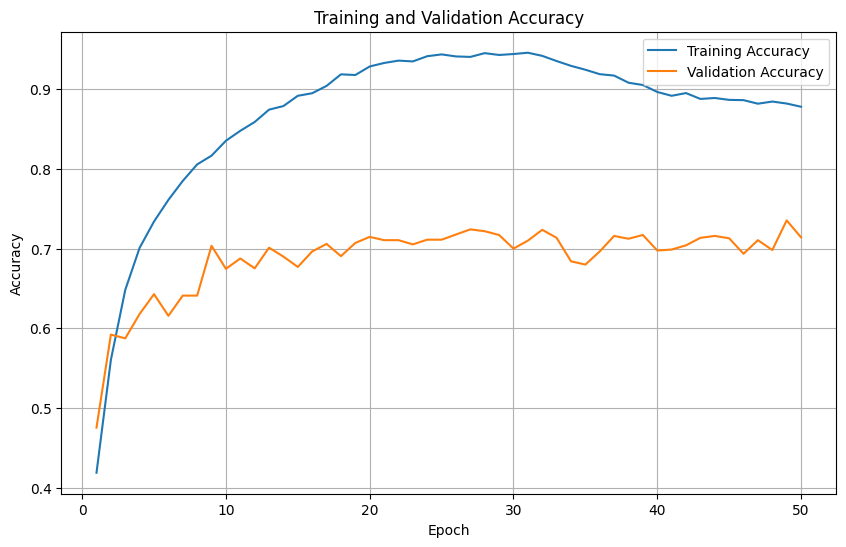

In [43]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train model:   0.0 hours,   4.0 minutes,   0 seconds
Test acc: 0.679


In [45]:
torch.save(model, path_to_save+'cnn')

## shallow cnn

In [46]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [47]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=25,
                 stride=1,
                 padding=0,
                 pool_kernel=50,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.AvgPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
        )

        self.dense = nn.Linear(in_features=depth * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [48]:
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
Shallow                                  [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 376]             --
│    └─Conv1d: 2-1                       [64, 25, 376]             13,775
│    └─ReLU: 2-2                         [64, 25, 376]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 376]             50
│    └─Dropout: 2-4                      [64, 25, 376]             --
├─Sequential: 1-2                        [64, 200, 1, 7]           --
│    └─Conv2d: 2-5                       [64, 200, 1, 352]         125,200
│    └─ELU: 2-6                          [64, 200, 1, 352]         --
│    └─BatchNorm2d: 2-7                  [64, 200, 1, 352]         400
│    └─AvgPool2d: 2-8                    [64, 200, 1, 7]           --
│    └─Dropout: 2-9                      [64, 200, 1, 7]           --
│    └─Tanh: 2-10                        [64, 200, 1, 7]           --
├─Seq

In [49]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02, weight_decay=0.005, momentum=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.277, Val acc: 0.273, Val loss: 1.384
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.302, Val loss: 1.401
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.316, Val acc: 0.277, Val loss: 1.370
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.268, Val loss: 1.382
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.326, Val acc: 0.319, Val loss: 1.388
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.292, Val loss: 1.383
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.331, Val acc: 0.293, Val loss: 1.450
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.238, Val loss: 1.372
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.294, Val loss: 1.365
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.265, Val loss: 1.419
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.322, Val acc: 0.279, Val loss: 1.381
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.328, Val acc: 0.291, Val loss: 1.396
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.335, Val acc: 0.271, Val loss: 1.385
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.333, Val acc: 0.277, Val loss: 1.394
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.337, Val acc: 0.243, Val loss: 1.461
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.244, Val loss: 1.358
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.340, Val acc: 0.279, Val loss: 1.358
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.284, Val loss: 1.429
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.239, Val loss: 1.421
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.291, Val loss: 1.426
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.347, Val acc: 0.270, Val loss: 1.433
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.288, Val loss: 1.417
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.351, Val acc: 0.275, Val loss: 1.424
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.361, Val acc: 0.296, Val loss: 1.430
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.362, Val acc: 0.292, Val loss: 1.448
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.364, Val acc: 0.320, Val loss: 1.404
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.325, Val loss: 1.395
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.302, Val loss: 1.362
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.301, Val loss: 1.433
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.375, Val acc: 0.278, Val loss: 1.391
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.292, Val loss: 1.413
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.385, Val acc: 0.293, Val loss: 1.355
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.267, Val loss: 1.411
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.323, Val loss: 1.421
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.392, Val acc: 0.271, Val loss: 1.386
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.269, Val loss: 1.383
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.276, Val loss: 1.376
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.291, Val loss: 1.412
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.283, Val loss: 1.403
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.285, Val loss: 1.409
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.302, Val loss: 1.348
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.325, Val loss: 1.473
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.440, Val acc: 0.312, Val loss: 1.520
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.316, Val loss: 1.388
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.327, Val loss: 1.433
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'shallow_cnn')

## cnn lstm

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=3,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=depth * 8,
                      out_features=depth * 8),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            # TimeDistributed(nn.Dropout(dropout)),
            # TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            # TimeDistributed(nn.ReLU()),
            # TimeDistributed(nn.BatchNorm1d(depth * 2)),
            # TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 4, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 4, out_features=depth * 2),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth * 2),
            # nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 2, out_features=depth),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.linear(x)
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        #x = self.td(x)
        x = self.nd(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [ ]:
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [ ]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'cnn_lstm')

## cnn gru

In [ ]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [ ]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 4,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth * 8, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x, _ = self.gru(x)
        #x = self.td(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [ ]:
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

In [ ]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'cnn_gru')

## lstm-lstm

In [ ]:
class LSTM_LSTM(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 2,
                 output_size = 54,
                 num_classes = 4):
        super(LSTM_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size * 2,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)


        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through LSTM1
        out, _ = self.lstm1(x)

        # Forward pass through LSTM2
        out, _ = self.lstm2(out)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [ ]:
torchinfo.summary(LSTM_LSTM(), input_size=(batch_size, 22, 400))

In [ ]:
model = LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'lstm_lstm')

## gru

In [ ]:
class GRU(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 3,
                 output_size = 54,
                 num_classes = 4):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)

        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through GRU
        out, _ = self.gru(x)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [ ]:
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

In [ ]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

In [ ]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

In [ ]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

In [ ]:
torch.save(model, path_to_save+'gru')

# end

In [ ]:
print('time i will never get back:')
hours = (end_time - super_start_time) // 3600
minutes = ((end_time - super_start_time) % 3600) // 60
seconds = (end_time - super_start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

# GOOD CNN

In [ ]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask 0

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [20]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [25]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.607, Val loss: 1.023
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.687, Val loss: 0.749
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.721, Val loss: 0.639
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.721, Val loss: 0.558
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.736, Val loss: 0.531
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.768, Val loss: 0.667
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.764, Val loss: 0.536
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.761, Val loss: 0.684
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.774, Val loss: 0.536
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.757, Val loss: 0.511
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.782, Val loss: 0.478
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.768, Val loss: 0.680
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.746, Val loss: 0.613
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.742, Val loss: 0.593
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.751, Val loss: 0.589
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.758, Val loss: 0.617
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.729, Val loss: 0.731
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.758, Val loss: 0.700
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.758, Val loss: 0.472
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.752, Val loss: 0.633
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.770, Val loss: 0.623
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.775, Val loss: 0.610
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.752, Val loss: 0.561
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.719, Val loss: 0.612
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.767, Val loss: 0.503
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.770, Val loss: 0.612
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.753, Val loss: 0.550
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.761, Val loss: 0.621
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.763, Val loss: 0.705
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.772, Val loss: 0.501
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.798, Val loss: 0.553
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.803, Val loss: 0.564
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.801, Val loss: 0.587
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.798, Val loss: 0.546
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.801, Val loss: 0.553
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.804, Val loss: 0.550
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.801, Val loss: 0.549
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.807, Val loss: 0.582
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.802, Val loss: 0.582
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.807, Val loss: 0.547
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.794, Val loss: 0.581
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.800, Val loss: 0.560
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.566
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.803, Val loss: 0.568
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.802, Val loss: 0.569
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.802, Val loss: 0.575
Epoch 47


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.564
Epoch 48


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.563
Epoch 49


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 50


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.555
Epoch 51


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.561
Epoch 52


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.561
Epoch 53


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 54


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.557
Epoch 55


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.562
Epoch 56


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 57


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.562
Epoch 58


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 59


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.805, Val loss: 0.559
Epoch 60


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.560
Epoch 61


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.805, Val loss: 0.561
Epoch 62


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.562
Epoch 63


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.560
Epoch 64


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.811, Val loss: 0.562
Epoch 65


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.566
Epoch 66


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 67


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.566
Epoch 68


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.561
Epoch 69


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.563
Epoch 70


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.563
Epoch 71


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 72


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.565
Epoch 73


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.561
Epoch 74


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.560
Epoch 75


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.808, Val loss: 0.566
Epoch 76


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.563
Epoch 77


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 78


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.563
Epoch 79


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.811, Val loss: 0.565
Epoch 80


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.558
Epoch 81


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 82


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.562
Epoch 83


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.568
Epoch 84


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.562
Epoch 85


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.561
Epoch 86


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 87


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.564
Epoch 88


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.814, Val loss: 0.567
Epoch 89


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.560
Epoch 90


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 91


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.570
Epoch 92


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.559
Epoch 93


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.566
Epoch 94


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.563
Epoch 95


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.558
Epoch 96


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 97


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.812, Val loss: 0.564
Epoch 98


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.806, Val loss: 0.559
Epoch 99


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.806, Val loss: 0.556
Epoch 100


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.808, Val loss: 0.562


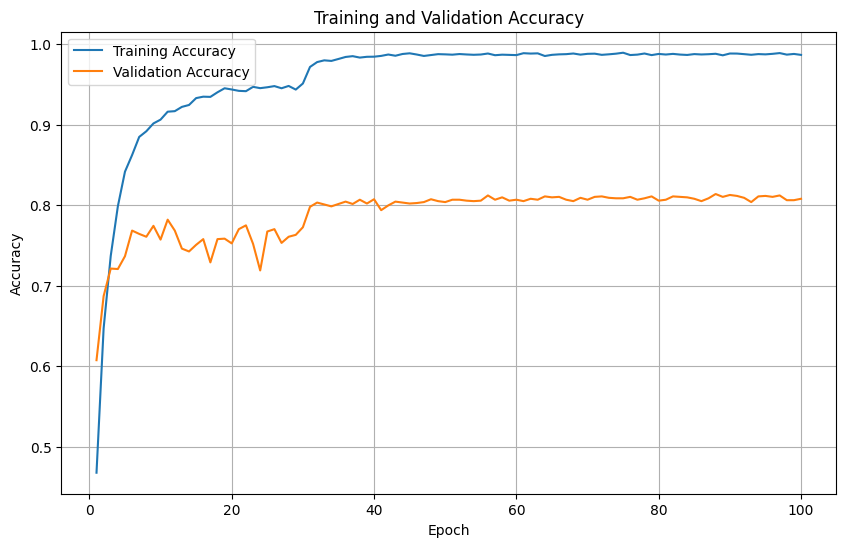

In [26]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
test_model(model, test_loader)

Test acc: 0.743


In [28]:
torch.save(model, './hopefully_better/cnn')

In [ ]:
# batch size 64
# channel dropout 0.01
# noise True
# smooth_time_mask 0

In [12]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [20]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [25]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.607, Val loss: 1.023
Epoch 2


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.687, Val loss: 0.749
Epoch 3


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.737, Val acc: 0.721, Val loss: 0.639
Epoch 4


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.798, Val acc: 0.721, Val loss: 0.558
Epoch 5


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.841, Val acc: 0.736, Val loss: 0.531
Epoch 6


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.862, Val acc: 0.768, Val loss: 0.667
Epoch 7


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.764, Val loss: 0.536
Epoch 8


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.892, Val acc: 0.761, Val loss: 0.684
Epoch 9


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.901, Val acc: 0.774, Val loss: 0.536
Epoch 10


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.906, Val acc: 0.757, Val loss: 0.511
Epoch 11


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.916, Val acc: 0.782, Val loss: 0.478
Epoch 12


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.917, Val acc: 0.768, Val loss: 0.680
Epoch 13


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.922, Val acc: 0.746, Val loss: 0.613
Epoch 14


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.924, Val acc: 0.742, Val loss: 0.593
Epoch 15


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.933, Val acc: 0.751, Val loss: 0.589
Epoch 16


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.935, Val acc: 0.758, Val loss: 0.617
Epoch 17


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.934, Val acc: 0.729, Val loss: 0.731
Epoch 18


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.940, Val acc: 0.758, Val loss: 0.700
Epoch 19


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.758, Val loss: 0.472
Epoch 20


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.944, Val acc: 0.752, Val loss: 0.633
Epoch 21


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.942, Val acc: 0.770, Val loss: 0.623
Epoch 22


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.941, Val acc: 0.775, Val loss: 0.610
Epoch 23


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.947, Val acc: 0.752, Val loss: 0.561
Epoch 24


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.719, Val loss: 0.612
Epoch 25


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.946, Val acc: 0.767, Val loss: 0.503
Epoch 26


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.770, Val loss: 0.612
Epoch 27


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.945, Val acc: 0.753, Val loss: 0.550
Epoch 28


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.948, Val acc: 0.761, Val loss: 0.621
Epoch 29


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.943, Val acc: 0.763, Val loss: 0.705
Epoch 30


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.951, Val acc: 0.772, Val loss: 0.501
Epoch 31


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.971, Val acc: 0.798, Val loss: 0.553
Epoch 32


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.978, Val acc: 0.803, Val loss: 0.564
Epoch 33


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.980, Val acc: 0.801, Val loss: 0.587
Epoch 34


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.979, Val acc: 0.798, Val loss: 0.546
Epoch 35


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.981, Val acc: 0.801, Val loss: 0.553
Epoch 36


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.804, Val loss: 0.550
Epoch 37


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.801, Val loss: 0.549
Epoch 38


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.983, Val acc: 0.807, Val loss: 0.582
Epoch 39


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.802, Val loss: 0.582
Epoch 40


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.984, Val acc: 0.807, Val loss: 0.547
Epoch 41


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.794, Val loss: 0.581
Epoch 42


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.800, Val loss: 0.560
Epoch 43


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.566
Epoch 44


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.803, Val loss: 0.568
Epoch 45


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.802, Val loss: 0.569
Epoch 46


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.802, Val loss: 0.575
Epoch 47


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.804, Val loss: 0.564
Epoch 48


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.563
Epoch 49


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 50


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.555
Epoch 51


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.561
Epoch 52


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.561
Epoch 53


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 54


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.557
Epoch 55


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.562
Epoch 56


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 57


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.562
Epoch 58


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 59


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.805, Val loss: 0.559
Epoch 60


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.807, Val loss: 0.560
Epoch 61


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.805, Val loss: 0.561
Epoch 62


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.562
Epoch 63


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.560
Epoch 64


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.985, Val acc: 0.811, Val loss: 0.562
Epoch 65


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.566
Epoch 66


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.561
Epoch 67


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.566
Epoch 68


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.561
Epoch 69


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.563
Epoch 70


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.807, Val loss: 0.563
Epoch 71


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 72


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.565
Epoch 73


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.561
Epoch 74


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.560
Epoch 75


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.808, Val loss: 0.566
Epoch 76


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.563
Epoch 77


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 78


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.808, Val loss: 0.563
Epoch 79


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.811, Val loss: 0.565
Epoch 80


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.805, Val loss: 0.558
Epoch 81


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.807, Val loss: 0.553
Epoch 82


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.562
Epoch 83


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.810, Val loss: 0.568
Epoch 84


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.562
Epoch 85


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.561
Epoch 86


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.805, Val loss: 0.558
Epoch 87


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.808, Val loss: 0.564
Epoch 88


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.814, Val loss: 0.567
Epoch 89


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.810, Val loss: 0.560
Epoch 90


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.812, Val loss: 0.564
Epoch 91


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.811, Val loss: 0.570
Epoch 92


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.809, Val loss: 0.559
Epoch 93


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.804, Val loss: 0.566
Epoch 94


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.563
Epoch 95


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.811, Val loss: 0.558
Epoch 96


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.810, Val loss: 0.563
Epoch 97


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.989, Val acc: 0.812, Val loss: 0.564
Epoch 98


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.987, Val acc: 0.806, Val loss: 0.559
Epoch 99


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.988, Val acc: 0.806, Val loss: 0.556
Epoch 100


  0%|          | 0/238 [00:00<?, ?it/s]

Train acc: 0.986, Val acc: 0.808, Val loss: 0.562


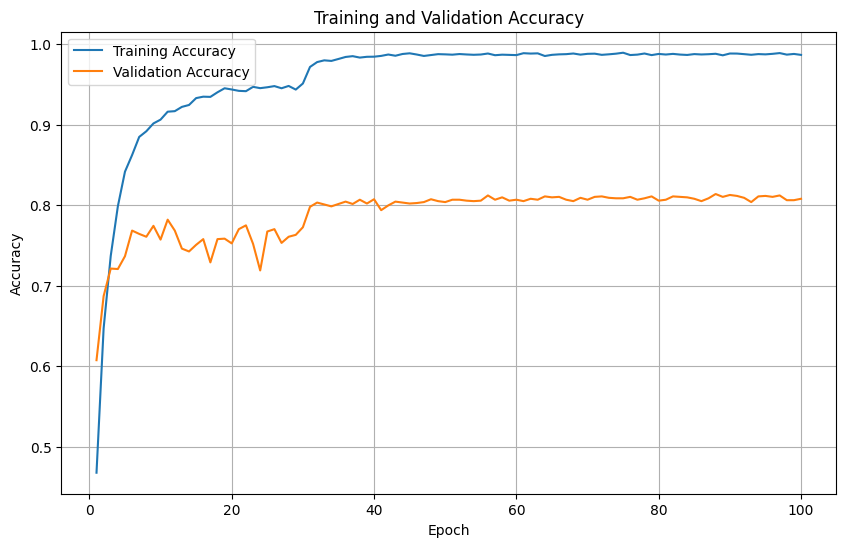

In [26]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
test_model(model, test_loader)

Test acc: 0.743


In [28]:
torch.save(model, './hopefully_better/cnn')

In [15]:
from torchinfo import summary

model = CNN(num_classes=4,
          dropout=0.3647999634687216,
          kernel1=5,
          kernel2=(1, 25),
          kernel3=6,
          kernel4=5,
          pool_kernel=3).to(device)
summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=0.001767340543208569,
                               weight_decay=0.008272087903010924)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001, last_epoch=100)

In [17]:
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Val acc: 0.261, Val loss: 1.391
Epoch 2


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.238, Val acc: 0.261, Val loss: 1.392
Epoch 3


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.263, Val loss: 1.392
Epoch 4


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.262, Val loss: 1.393
Epoch 5


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.259, Val loss: 1.390
Epoch 6


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.258, Val loss: 1.390
Epoch 7


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Val acc: 0.264, Val loss: 1.393
Epoch 8


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.245, Val acc: 0.259, Val loss: 1.389
Epoch 9


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.264, Val loss: 1.392
Epoch 10


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.264, Val loss: 1.391
Epoch 11


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.259, Val loss: 1.391
Epoch 12


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.259, Val loss: 1.390
Epoch 13


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Val acc: 0.263, Val loss: 1.392
Epoch 14


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.261, Val loss: 1.390
Epoch 15


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.247, Val acc: 0.263, Val loss: 1.391
Epoch 16


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.263, Val loss: 1.390
Epoch 17


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.261, Val loss: 1.395
Epoch 18


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.242, Val acc: 0.261, Val loss: 1.389
Epoch 19


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.245, Val acc: 0.263, Val loss: 1.392
Epoch 20


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.246, Val acc: 0.261, Val loss: 1.390
Epoch 21


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.257, Val loss: 1.390
Epoch 22


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.260, Val acc: 0.258, Val loss: 1.389
Epoch 23


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.264, Val loss: 1.392
Epoch 24


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.258, Val loss: 1.393
Epoch 25


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.239, Val acc: 0.262, Val loss: 1.393
Epoch 26


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.262, Val loss: 1.393
Epoch 27


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.263, Val loss: 1.392
Epoch 28


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.242, Val acc: 0.263, Val loss: 1.393
Epoch 29


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.240, Val acc: 0.263, Val loss: 1.391
Epoch 30


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.259, Val loss: 1.392
Epoch 31


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Val acc: 0.262, Val loss: 1.393
Epoch 32


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.258, Val loss: 1.390
Epoch 33


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.263, Val loss: 1.391
Epoch 34


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.240, Val acc: 0.263, Val loss: 1.392
Epoch 35


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.243, Val acc: 0.261, Val loss: 1.390
Epoch 36


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.263, Val loss: 1.393
Epoch 37


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.244, Val acc: 0.258, Val loss: 1.389
Epoch 38


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.247, Val acc: 0.261, Val loss: 1.391
Epoch 39


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.242, Val acc: 0.261, Val loss: 1.392
Epoch 40


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.241, Val acc: 0.261, Val loss: 1.391
Epoch 41


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.262, Val loss: 1.392
Epoch 42


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.264, Val loss: 1.391
Epoch 43


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.247, Val acc: 0.264, Val loss: 1.389
Epoch 44


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.242, Val acc: 0.264, Val loss: 1.390
Epoch 45


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.264, Val loss: 1.391
Epoch 46


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.256, Val acc: 0.259, Val loss: 1.393
Epoch 47


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.248, Val acc: 0.259, Val loss: 1.392
Epoch 48


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.263, Val loss: 1.391
Epoch 49


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.235, Val acc: 0.265, Val loss: 1.391
Epoch 50


  0%|          | 0/119 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.264, Val loss: 1.391


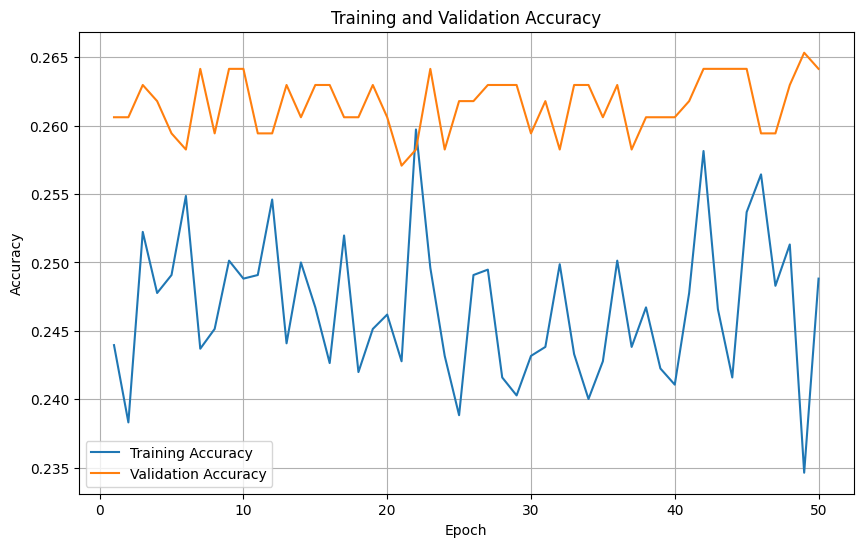

In [18]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
test_model(model, test_loader)

Test acc: 0.217


In [20]:
torch.save(model, './hopefully_better/cnn-seeded-with-augments')